# Electricity Usage Visualizations

This notebook loads `combined_electricity_data.csv` and generates several common visualizations.

**Columns expected**
- `state` (2-letter code)
- `year` (int)
- `sector` (categorical; e.g., Residential/Commercial/Industrial)
- `electricity_usage` (numeric)

> Tip: If you want to focus on a specific state, set `FOCUS_STATE` below.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\STA\Downloads\New folder\combined_electricity_data.csv"

df = pd.read_csv(CSV_PATH)
df.head()


,state,year,sector,electricity_usage
0,AK,1990,Commercial,1972116
1,AK,1990,Industrial,459282
2,AK,1990,Residential,1661311
3,AK,1991,Commercial,2005247
4,AK,1991,Industrial,465878


In [2]:
# Basic checks / cleanup
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
df['electricity_usage'] = pd.to_numeric(df['electricity_usage'], errors='coerce')

# Drop rows with missing essentials
df = df.dropna(subset=['state', 'year', 'sector', 'electricity_usage']).copy()

df['state'] = df['state'].astype(str).str.strip().str.upper()
df['sector'] = df['sector'].astype(str).str.strip()

print("Rows:", len(df))
print("States:", df['state'].nunique())
print("Years:", int(df['year'].min()), "to", int(df['year'].max()))
print("Sectors:", sorted(df['sector'].unique()))
df.describe(include='all')


Rows: 5355
States: 51
Years: 1990 to 2024
Sectors: ['Commercial', 'Industrial', 'Residential']


,state,year,sector,electricity_usage
count,5355,5355.0,5355,5.355000e+03
unique,51,<NA>,3,NaN
top,AK,<NA>,Commercial,NaN
freq,105,<NA>,1785,NaN
mean,NaN,2007.0,NaN,2.260589e+07
std,NaN,10.100448,NaN,2.376308e+07
min,NaN,1990.0,NaN,1.764890e+05
25%,NaN,1998.0,NaN,6.145314e+06
50%,NaN,2007.0,NaN,1.579150e+07
75%,NaN,2016.0,NaN,3.054225e+07


## 1) National trend by sector (sum across states)

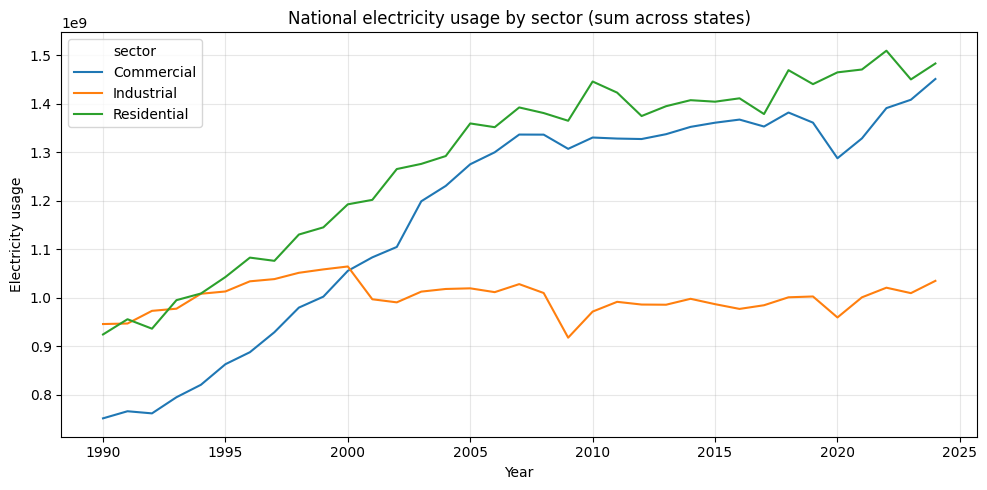

In [3]:
# Aggregate to national totals by year & sector
nat = (df.groupby(['year', 'sector'], as_index=False)['electricity_usage']
         .sum()
         .sort_values(['year', 'sector']))

# Pivot for plotting
nat_piv = nat.pivot(index='year', columns='sector', values='electricity_usage').sort_index()

ax = nat_piv.plot(kind='line', figsize=(10, 5))
ax.set_title("National electricity usage by sector (sum across states)")
ax.set_xlabel("Year")
ax.set_ylabel("Electricity usage")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2) Stacked area: sector mix over time (national)

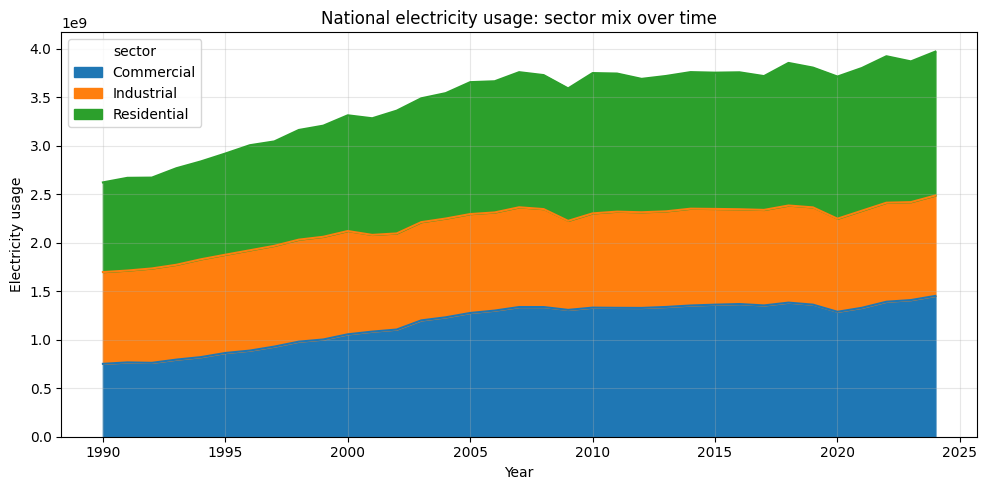

In [4]:
ax = nat_piv.plot(kind='area', stacked=True, figsize=(10, 5))
ax.set_title("National electricity usage: sector mix over time")
ax.set_xlabel("Year")
ax.set_ylabel("Electricity usage")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3) Latest-year ranking: top states by total usage

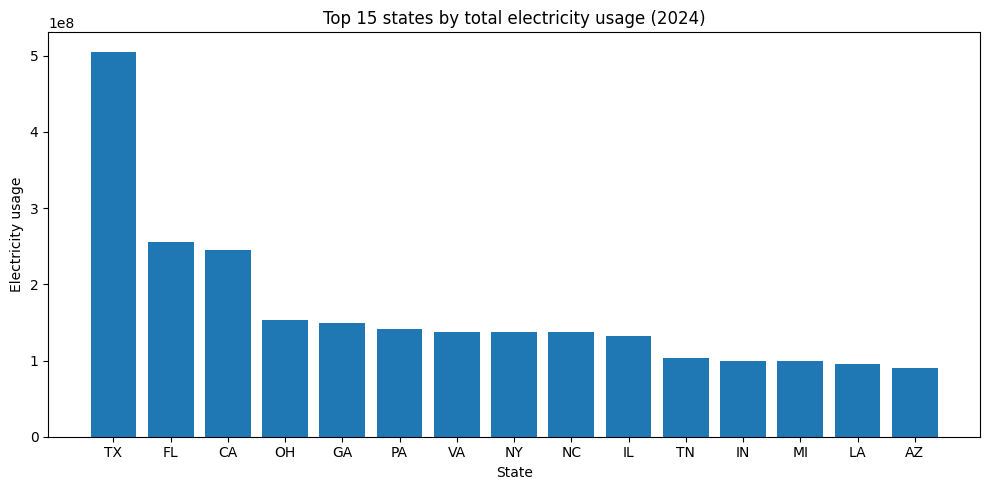

,state,electricity_usage
43,TX,505419786
9,FL,255025540
4,CA,245002045
35,OH,153675730
10,GA,149852296


In [5]:
latest_year = int(df['year'].max())
latest = df[df['year'] == latest_year].copy()

by_state_latest = (latest.groupby('state', as_index=False)['electricity_usage']
                         .sum()
                         .sort_values('electricity_usage', ascending=False))

top_n = 15
top = by_state_latest.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top['state'], top['electricity_usage'])
plt.title(f"Top {top_n} states by total electricity usage ({latest_year})")
plt.xlabel("State")
plt.ylabel("Electricity usage")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

top.head()


## 4) Focused state trend by sector

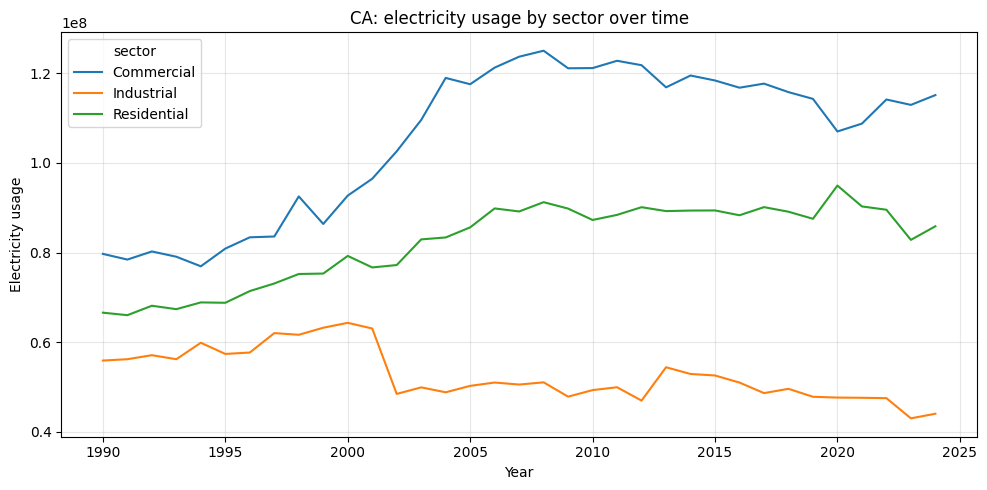

In [6]:
# Change this to any available state code (e.g., 'CA', 'TX', 'NY')
FOCUS_STATE = 'CA'

state_df = df[df['state'] == FOCUS_STATE].copy()
if state_df.empty:
    raise ValueError(f"No data found for state={FOCUS_STATE}. Try one of: {sorted(df['state'].unique())[:20]} ...")

state_piv = (state_df.groupby(['year', 'sector'], as_index=False)['electricity_usage']
                    .sum()
                    .pivot(index='year', columns='sector', values='electricity_usage')
                    .sort_index())

ax = state_piv.plot(kind='line', figsize=(10, 5))
ax.set_title(f"{FOCUS_STATE}: electricity usage by sector over time")
ax.set_xlabel("Year")
ax.set_ylabel("Electricity usage")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5) Heatmap: states vs years (total usage)

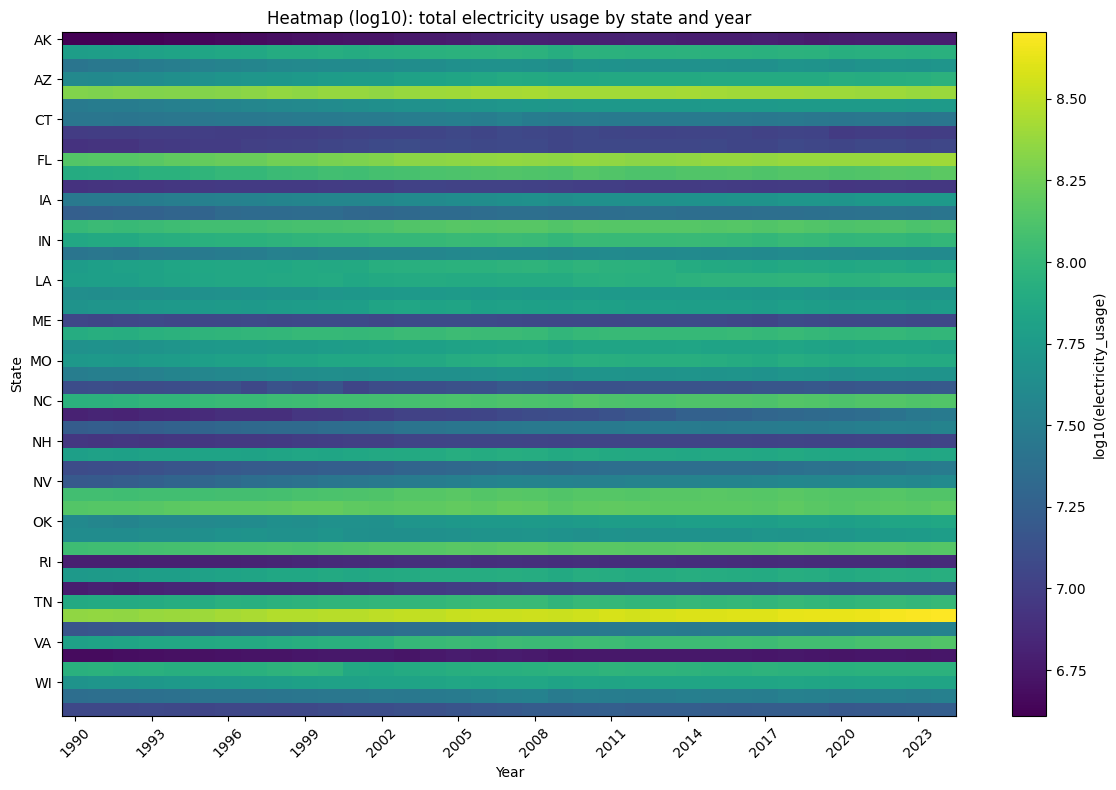

In [12]:
# Build matrix: rows=states, cols=years, values=total usage (all sectors)
mat = (df.groupby(['state', 'year'], as_index=False)['electricity_usage']
         .sum()
         .pivot(index='state', columns='year', values='electricity_usage')
         .sort_index())

# For readability, use log10 scale (optional). Comment out if you want raw values.
mat_plot = np.log10(mat)

plt.figure(figsize=(12, 8))
plt.imshow(mat_plot, aspect='auto')
plt.title("Heatmap (log10): total electricity usage by state and year")
plt.xlabel("Year")
plt.ylabel("State")
plt.xticks(ticks=np.arange(len(mat.columns))[::max(1, len(mat.columns)//10)],
           labels=mat.columns[::max(1, len(mat.columns)//10)], rotation=45)
plt.yticks(ticks=np.arange(len(mat.index))[::max(1, len(mat.index)//15)],
           labels=mat.index[::max(1, len(mat.index)//15)])
plt.colorbar(label="log10(electricity_usage)")
plt.tight_layout()
plt.show()


## 6) Sector share by state (latest year)

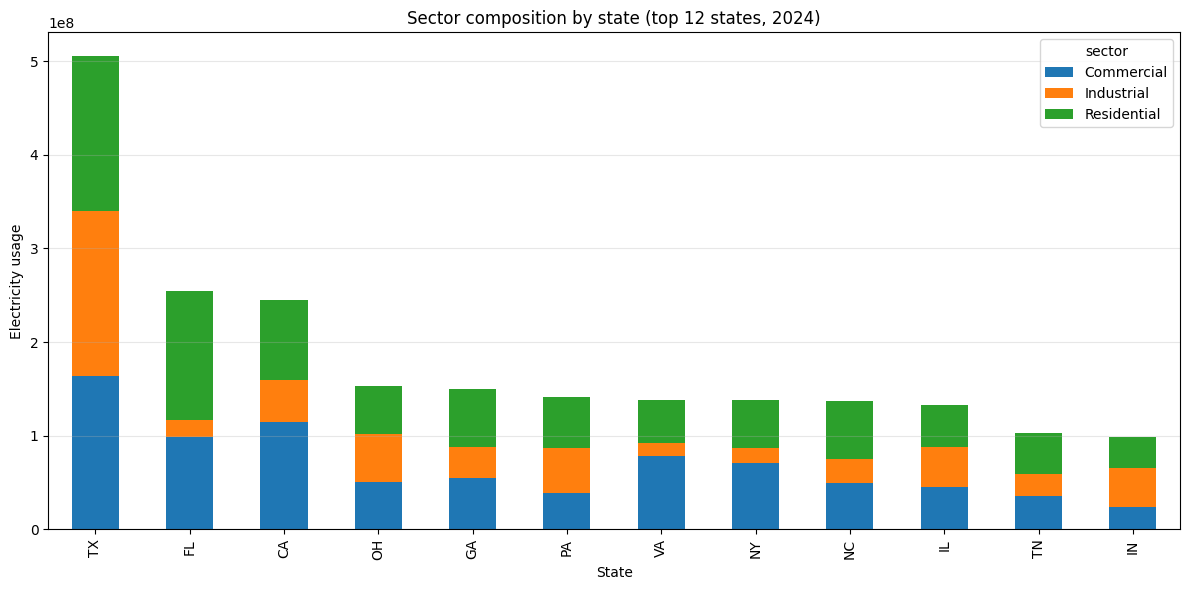

In [8]:
# Sector composition per state in latest year (stacked bar for top states)
latest_year = int(df['year'].max())
latest = df[df['year'] == latest_year].copy()

state_sector = (latest.groupby(['state', 'sector'], as_index=False)['electricity_usage']
                      .sum())

# pick top states by total
top_states = (state_sector.groupby('state', as_index=False)['electricity_usage']
                        .sum()
                        .sort_values('electricity_usage', ascending=False)
                        .head(12)['state'])

ss = state_sector[state_sector['state'].isin(top_states)]
ss_piv = ss.pivot(index='state', columns='sector', values='electricity_usage').fillna(0)
ss_piv = ss_piv.loc[top_states]  # keep ranking order

ax = ss_piv.plot(kind='bar', stacked=True, figsize=(12, 6))
ax.set_title(f"Sector composition by state (top 12 states, {latest_year})")
ax.set_xlabel("State")
ax.set_ylabel("Electricity usage")
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
